In [50]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

# Data Set Exploration

In [51]:
df = pd.read_csv('data.csv')

In [52]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Check for duplicated values and missing ones

In [53]:
# Check for missing values

df.columns[df.isna().sum()>0]

Index([], dtype='object')

In [54]:
# Check for duplicates and drop them

df[df.duplicated()]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


In [55]:
df.drop_duplicates(inplace=True)

## Check the ratios of two classes in the dataset

In [56]:
print(f'Non Fraud Transactions Ratio : {round(100*df[df.Class == 0].count()['Class']/len(df),2)}')
print(f'Fraud Transactions Ratio: {round(100*df[df.Class == 1].count()['Class']/len(df),2)}')

Non Fraud Transactions Ratio : 99.83
Fraud Transactions Ratio: 0.17


## Prepare training and test sets

In [57]:
X = df.drop('Class', axis=1)
y = df[['Class']]

# We split into training and testing sets using stratify option so that we have the same ratios of two classes in the two subsets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [43]:
print(f'Non Fraud Transactions in train set: ratio = {round(100*y_train[y_train.Class == 0].count()['Class']/len(y_train),2)}, number = {y_train[y_train.Class == 0].count()['Class']}')
print(f'Fraud Transactions Ratio in train set: ratio = {round(100*y_train[y_train.Class == 1].count()['Class']/len(y_train),2)}, number = {y_train[y_train.Class == 1].count()['Class']}')
print(f'Non Fraud Transactions Ratio in test set: ratio = {round(100*y_test[y_test.Class == 0].count()['Class']/len(y_test),2)}, number = {y_test[y_test.Class == 0].count()['Class']}')
print(f'Fraud Transactions Ratio in test set: ratio = {round(100*y_test[y_test.Class == 1].count()['Class']/len(y_test),2)}, number = {y_test[y_test.Class == 1].count()['Class']}')

Non Fraud Transactions in train set: ratio = 99.83, number = 226602
Fraud Transactions Ratio in train set: ratio = 0.17, number = 378
Non Fraud Transactions Ratio in test set: ratio = 99.83, number = 56651
Fraud Transactions Ratio in test set: ratio = 0.17, number = 95


## Split the training set into fraud and non fraud subsets + Chunking

In [ ]:
X_train_nonfraud = X_train[y_train['Class'] == 0]
X_train_fraud = X_train[y_train['Class'] == 1]

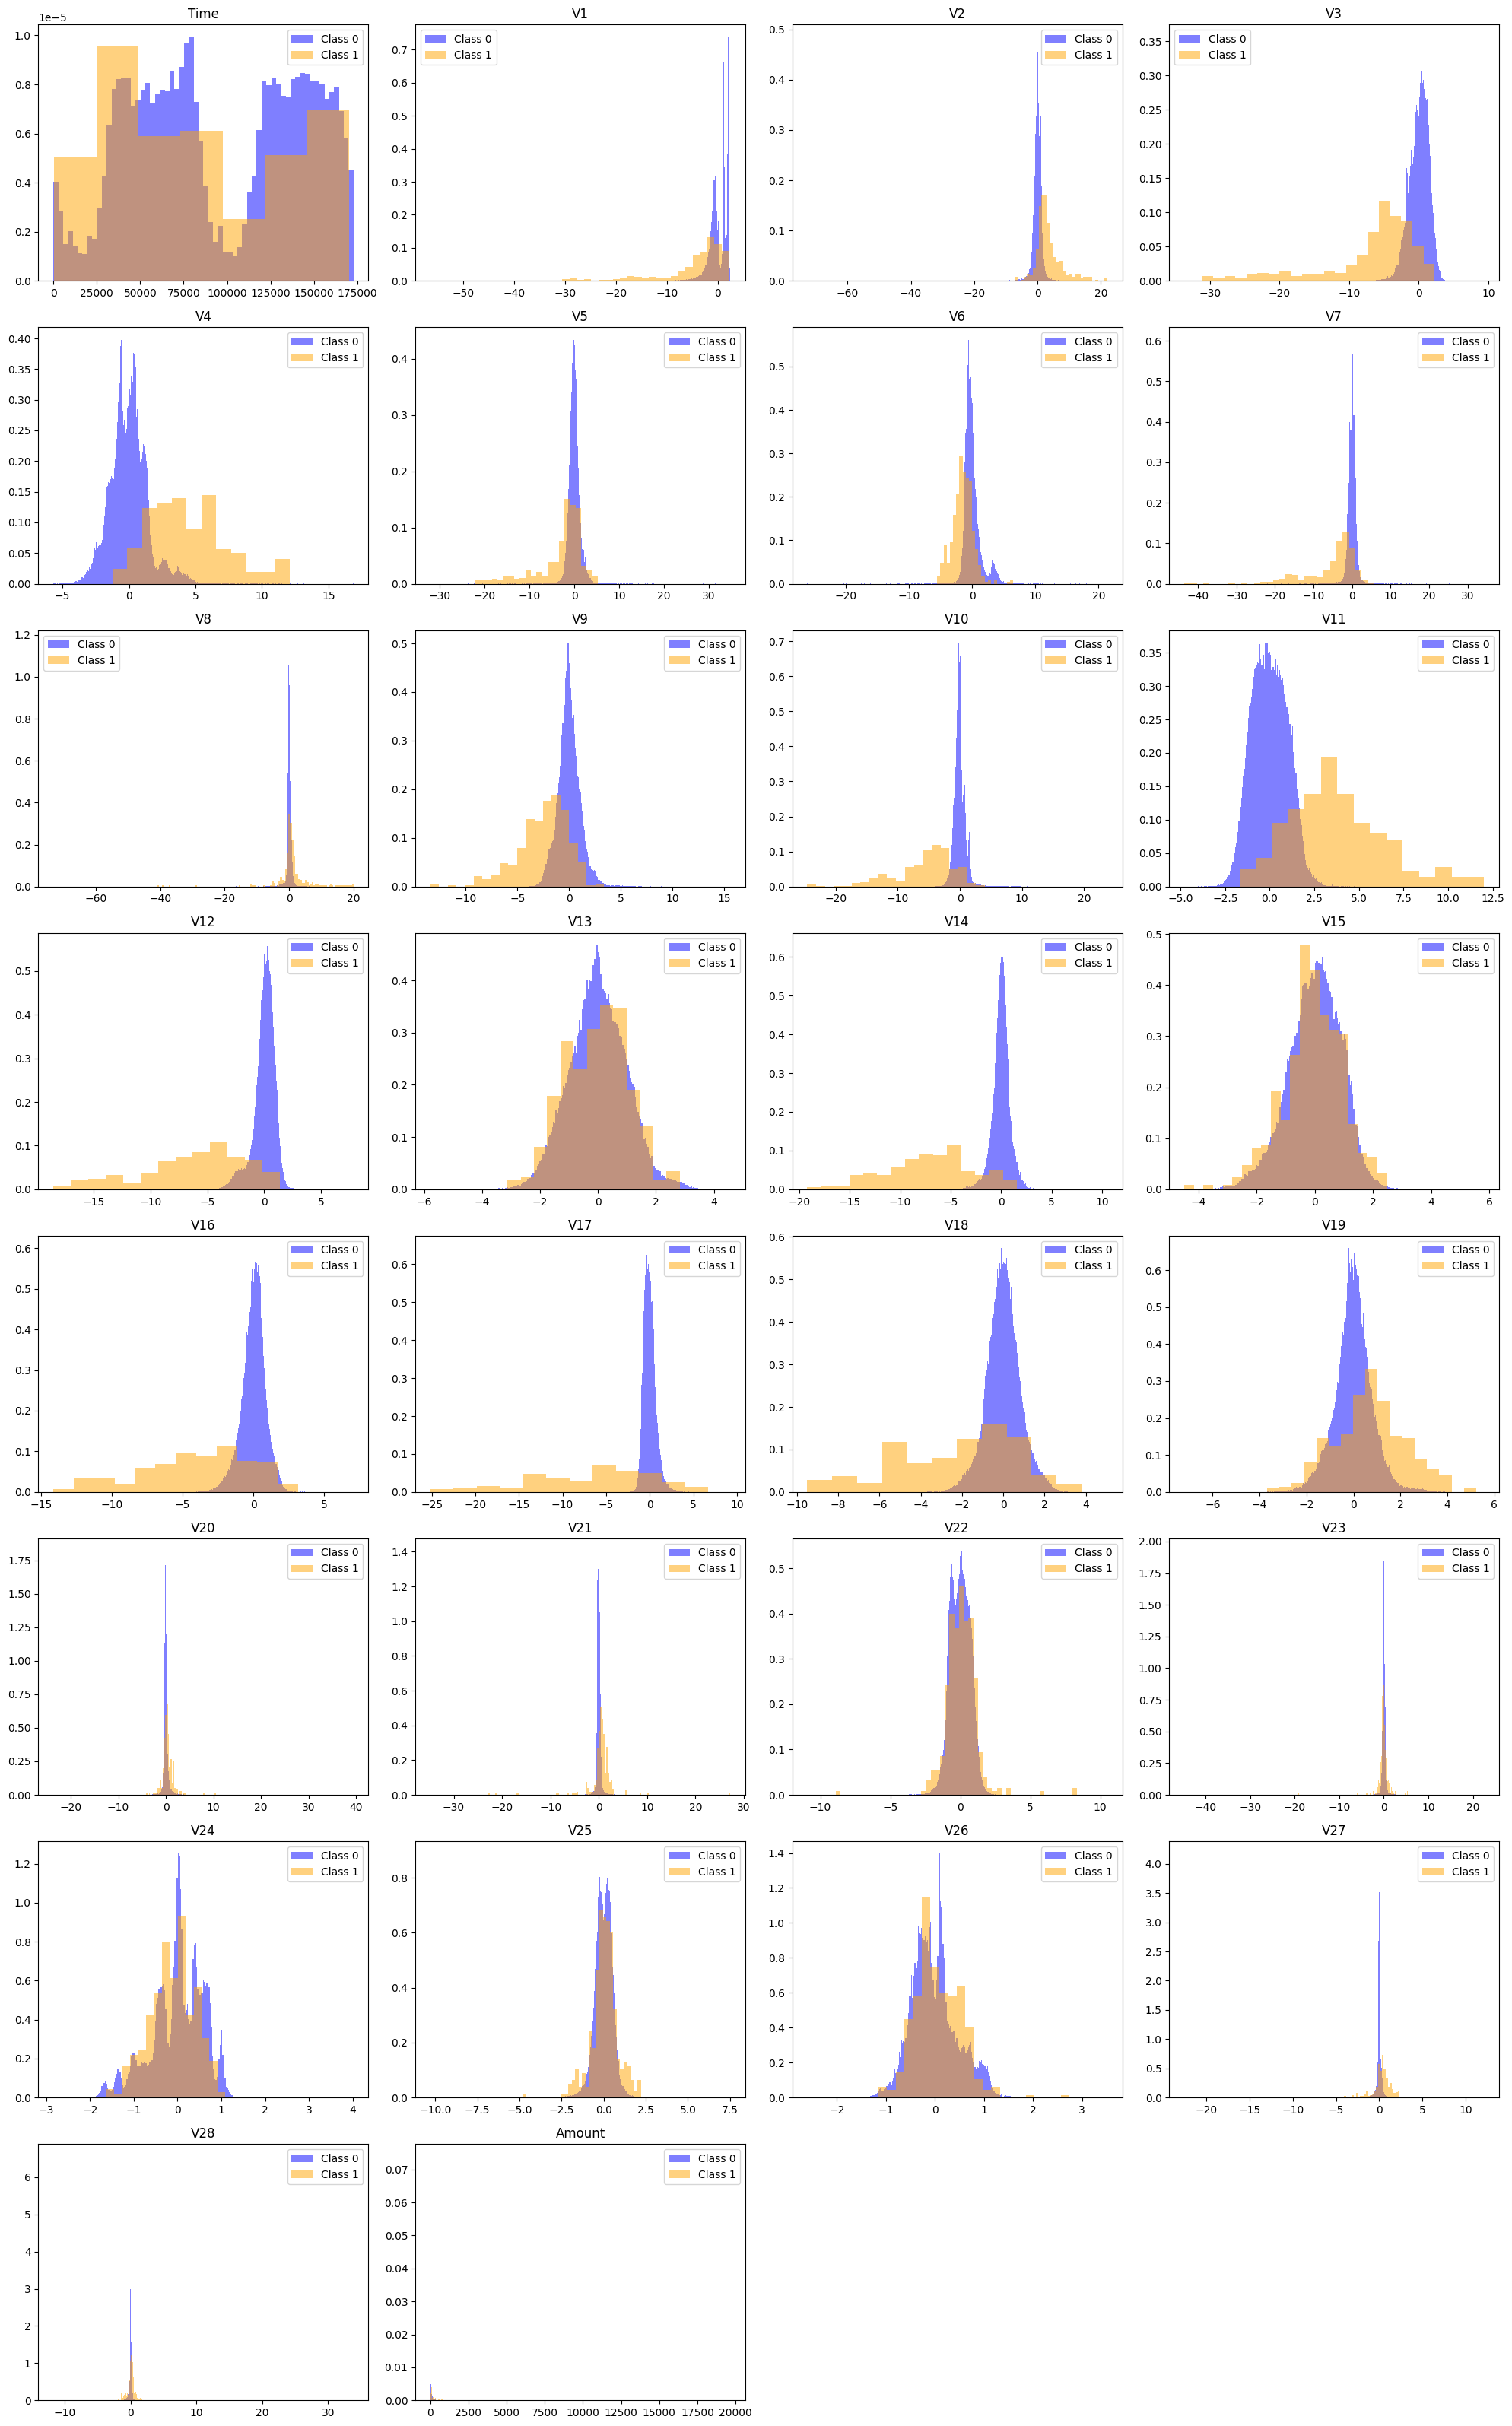

In [ ]:
features = X_train.columns
n_features = len(features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(X_train_nonfraud[feature], bins='fd', alpha=0.5, label='Class 0', color='blue', density=True)
    plt.hist(X_train_fraud[feature], bins='fd', alpha=0.5, label='Class 1', color='orange', density=True)
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()

We observe that a few features have very narrow peaks, which can obscure any heavy tails that might be present. In such cases, it is generally preferable to apply a log transformation for visualization. However, in our untransformed plots, even the peaks themselves differ, suggesting that a log transformation is unnecessary in this instance.

In [24]:
# We create chunks so that each one contains the same amount of non fraud transactions as we have of fraud ones in the training set

n_frauds = len(X_train_fraud)
n_nonfraud = len(X_train_nonfraud)

chunks = [X_train_nonfraud.iloc[i:i+n_frauds]
    for i in range(0, n_nonfraud, n_frauds)]

In [25]:
# If the last chunk has less data then total frauds in the traning set, we drop this chunk

if len(chunks[-1]) < n_frauds:
    chunks = chunks[:-1]

## Correlation heatmap

The correlation heatmap is computed as the average of cross correlations in each chunk.

In [26]:
avg_corr = chunks[0].corr()
for k in range(1,len(chunks)):
    avg_corr = avg_corr + chunks[k].corr()
avg_corr = avg_corr/len(chunks)

<Axes: >

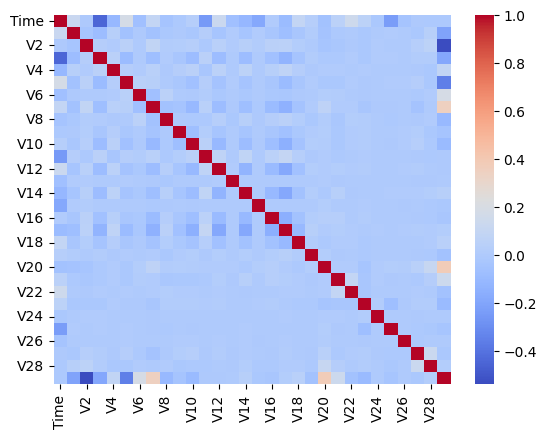

In [27]:
sns.heatmap(avg_corr,cmap='coolwarm')

# Model Selection - Cross Validation

## First Model (Decision Trees + Chunking)

Our first model follows this strategy: instead of training on the full imbalanced dataset, we split the data into multiple chunks. Each chunk contains all fraud transactions and an equal number of non-fraud transaction (each chunk has different non fraud transactions). A separate decision tree is trained on each chunk, and their predictions are averaged for the final output.

**Rationale**

* **Balanced training sets**: Each tree sees an equal number of fraud and non-fraud samples, reducing the bias toward the majority (non-fraud) class.
* **Use of all data points**: Across chunks, all available transactions—fraud and non-fraud—are included in training.
* **Variance reduction**: Averaging the predictions of multiple trees can reduce variance and improve generalization, especially when individual trees might overfit their small training subsets.
* **Pre-pruning**: Additional pre-pruning limits overfitting further.

**Limitations**

* **Tree dependence**: Since every chunk contains all fraud cases, the trees are not fully independent, limiting the effectiveness of variance reduction.
* **Limited number of chunks**: Fewer chunks mean fewer trees to average, which may further restrict variance reduction benefits.
* **Partial view of non-fraud distribution**: Because each chunk contains only a subset of non-fraud transactions, the model does not fully capture the diversity of the non-fraud class.

In [ ]:
# Parameter Grid
param_grid = {
    'max_depth': [2, 3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

# Prepare full training set
X_all = X_train.copy()
y_all = y_train['Class'].copy()

# Consider stratified K-fold, like this we keep fraud cases in our training sets during cross validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running cross-validation with chunked ensemble logic...\n")

# Grid Search
for max_depth in param_grid['max_depth']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            print(f"Params: depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf} ")

            fold_aucs = []
            fold_precisions = []
            fold_recalls = []
            fold_f1s = []
            k=1

            # Cross-validation
            for train_idx, val_idx in skf.split(X_all, y_all):

                X_fold_train, y_fold_train = X_all.iloc[train_idx], y_all.iloc[train_idx]
                X_fold_val, y_fold_val = X_all.iloc[val_idx], y_all.iloc[val_idx]

                # Split train into fraud and non-fraud
                X_fraud = X_fold_train[y_fold_train == 1]
                X_nonfraud = X_fold_train[y_fold_train == 0]

                n_frauds = len(X_fraud)
                chunks = [X_nonfraud.iloc[i:i+n_frauds]
                          for i in range(0, len(X_nonfraud), n_frauds)]
                
                # Skip if chunk size too small
                chunks = [chunk for chunk in chunks if len(chunk) == n_frauds]

                val_preds = []

                # Train model per chunk
                for chunk in chunks:
                    X_bal = pd.concat([X_fraud, chunk])
                    y_bal = pd.Series([1]*len(X_fraud) + [0]*len(chunk))

                    # Shuffle
                    idx = np.random.permutation(len(X_bal))
                    X_bal = X_bal.iloc[idx]
                    y_bal = y_bal.iloc[idx]

                    # Train model
                    model = DecisionTreeClassifier(
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        #class_weight='balanced',
                        random_state=42
                    )
                    model.fit(X_bal, y_bal)

                    # Predict on validation fold
                    probas = model.predict_proba(X_fold_val)[:, 1]
                    val_preds.append(probas)

                # Average predictions across chunk models
                avg_preds = np.mean(val_preds, axis=0)

                # ROC AUC
                auc = roc_auc_score(y_fold_val, avg_preds)
                fold_aucs.append(auc)

                # Threshold the predictions (e.g., 0.85)
                y_pred_class = (avg_preds > 0.85).astype(int)

                # Precision, Recall, F1
                precision = precision_score(y_fold_val, y_pred_class, zero_division=0)
                recall = recall_score(y_fold_val, y_pred_class, zero_division=0)
                f1 = f1_score(y_fold_val, y_pred_class, zero_division=0)

                print(f"Fold {k} -> Precision: {precision:.4f}, "
                  f"Recall: {recall:.4f}, F1: {f1:.4f}")

                fold_precisions.append(precision)
                fold_recalls.append(recall)
                fold_f1s.append(f1)
                k=1+k

            # Average metrics across folds
            mean_auc = np.mean(fold_aucs)
            mean_precision = np.mean(fold_precisions)
            mean_recall = np.mean(fold_recalls)
            mean_f1 = np.mean(fold_f1s)

            print(f"-->Average Precision: {mean_precision:.4f}, "
                  f"Average Recall: {mean_recall:.4f}, Average F1: {mean_f1:.4f}")
               

Running cross-validation with chunked ensemble logic...

Params: depth=2, split=2, leaf=1 
Fold 1 -> Precision: 0.2138, Recall: 0.7867, F1: 0.3362
Fold 2 -> Precision: 0.1585, Recall: 0.8667, F1: 0.2680
Fold 3 -> Precision: 0.1758, Recall: 0.8026, F1: 0.2884
Fold 4 -> Precision: 0.1515, Recall: 0.8553, F1: 0.2574
Fold 5 -> Precision: 0.2211, Recall: 0.8553, F1: 0.3514
-->Average Precision: 0.1841, Average Recall: 0.8333, Average F1: 0.3003
Params: depth=2, split=2, leaf=2 
Fold 1 -> Precision: 0.2206, Recall: 0.8000, F1: 0.3458
Fold 2 -> Precision: 0.1605, Recall: 0.8667, F1: 0.2708
Fold 3 -> Precision: 0.1794, Recall: 0.8026, F1: 0.2933
Fold 4 -> Precision: 0.1527, Recall: 0.8421, F1: 0.2586
Fold 5 -> Precision: 0.2226, Recall: 0.8553, F1: 0.3533
-->Average Precision: 0.1872, Average Recall: 0.8333, Average F1: 0.3044
Params: depth=2, split=2, leaf=5 
Fold 1 -> Precision: 0.2679, Recall: 0.8000, F1: 0.4013
Fold 2 -> Precision: 0.1650, Recall: 0.8667, F1: 0.2772
Fold 3 -> Precision: 0.

We see that different models with different parameters, precision is capped around 0.3 and recall 0.8. This means that the model captures 80% of fraud transactions, but also flags 70% of non fraud as fraud. The recall-precision tradeoff this model provides is not very good. One of the bests models parameters are depth=5, split=5, leaf=5 with Average Precision 0.3471, Average Recall 0.8413.

## Second Model (Balanced Random Forest)

In [ ]:
param_grid = {
    "n_estimators": [200, 400, 800],
    'max_depth': [2, 3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

X_all = X_train.copy()
y_all = y_train["Class"].copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for ne in param_grid["n_estimators"]:
    for md in param_grid["max_depth"]:
        for mss in param_grid["min_samples_split"]:
            for msl in param_grid["min_samples_leaf"]:
                print(f"Params: Number of estimators = {ne}, depth={md}, split={mss}, leaf={msl} ")

                ap_scores, roc_scores = [], []
                # we'll also tune a threshold per fold to report F1/precision/recall
                pr_list, rc_list, f1_list = [], [], []
                
                k = 1

                for tr, va in skf.split(X_all, y_all):
                    X_tr, y_tr = X_all.iloc[tr], y_all.iloc[tr]
                    X_va, y_va = X_all.iloc[va], y_all.iloc[va]

                    model = BalancedRandomForestClassifier(
                        n_estimators=ne,
                        max_depth=md,
                        min_samples_split=mss,
                        min_samples_leaf=msl,
                        random_state=42,
                        n_jobs=-1,
                    )
                    model.fit(X_tr, y_tr)
                    # Probabilities
                    p = model.predict_proba(X_va)[:, 1]

                    # Threshold-free metrics
                    ap_scores.append(average_precision_score(y_va, p))
                    roc_scores.append(roc_auc_score(y_va, p))

                    # Fixed threshold metrics (0.85)
                    y_hat = (p >= 0.85).astype(int)
                    pr = precision_score(y_va, y_hat, zero_division=0)
                    rc = recall_score(y_va, y_hat, zero_division=0)
                    f1 = f1_score(y_va, y_hat, zero_division=0)

                    pr_list.append(pr)
                    rc_list.append(rc)
                    f1_list.append(f1)
                    print(f"Fold {k} -> Precision: {pr:.4f}, "
                    f"Recall: {rc:.4f}, F1: {f1:.4f}")
                    k=1+k


                print(f"Precision: {np.mean(pr_list):.4f}, "
                    f"Recall: {np.mean(rc_list):.4f}, F1: {np.mean(f1_list):.4f}")


Params: Number of estimators = 200, depth=2, split=2, leaf=1 
Fold 1 -> Precision: 0.9000, Recall: 0.7200, F1: 0.8000
Fold 2 -> Precision: 0.8923, Recall: 0.7733, F1: 0.8286
Fold 3 -> Precision: 0.8545, Recall: 0.6184, F1: 0.7176
Fold 4 -> Precision: 0.8169, Recall: 0.7632, F1: 0.7891
Fold 5 -> Precision: 0.8611, Recall: 0.8158, F1: 0.8378
Precision: 0.8650, Recall: 0.7381, F1: 0.7946
Params: Number of estimators = 200, depth=2, split=2, leaf=2 
Fold 1 -> Precision: 0.9000, Recall: 0.7200, F1: 0.8000
Fold 2 -> Precision: 0.8923, Recall: 0.7733, F1: 0.8286
Fold 3 -> Precision: 0.8545, Recall: 0.6184, F1: 0.7176
Fold 4 -> Precision: 0.8169, Recall: 0.7632, F1: 0.7891
Fold 5 -> Precision: 0.8732, Recall: 0.8158, F1: 0.8435
Precision: 0.8674, Recall: 0.7381, F1: 0.7958
Params: Number of estimators = 200, depth=2, split=2, leaf=5 
Fold 1 -> Precision: 0.9000, Recall: 0.7200, F1: 0.8000
Fold 2 -> Precision: 0.8923, Recall: 0.7733, F1: 0.8286
Fold 3 -> Precision: 0.8491, Recall: 0.5921, F1: 0

We observe that all parameter settings yield almost the same precision and recall. I would prefer opting for a lower model complexity (e.g., limiting depth) to better control variance. Moreover, since the performance is stable, we can easily adjust the precision–recall trade-off by lowering or raising the threshold. The final choice should depend on the intended purpose of the model. I choose the model that provides stable precision and recall across all folds (i.e no severe drops across folds). For example, here are a two such models:

1. Number of estimators = 800, depth=None, split=5, leaf=1 (Precision: 0.8006, Recall: 0.8227), stable precision & recall -> maximum drop to 0.78 (only once)
4. Number of estimators = 200, depth=None, split=5, leaf=1 (0.8093, Recall: 0.8227), stable precision & recall -> maximum drop to 0.75 (only once)

For the final trainin we will use the first one.

# Final Train 1 (Chunking)

As discussed previously, we will use the following parameters: depth=5, split=5, leaf=5.

In [60]:
X_train_nonfraud = X_train[y_train['Class'] == 0]
X_train_fraud = X_train[y_train['Class'] == 1]

n_frauds = len(X_train_fraud)
n_nonfraud = len(X_train_nonfraud)

chunks = [X_train_nonfraud.iloc[i:i+n_frauds]
    for i in range(0, n_nonfraud, n_frauds)]

if len(chunks[-1]) < n_frauds:
    chunks = chunks[:-1]

test_preds = []

print(f"Training {len(chunks)} models...")
for chunk in tqdm(chunks):
    # Combine chunk of non-fraud with all fraud
    X_bal = pd.concat([X_train_fraud, chunk])
    y_bal = pd.Series([1]*len(X_train_fraud) + [0]*len(chunk))

    # Shuffle training data
    shuffled_idx = np.random.permutation(len(X_bal))
    X_bal = X_bal.iloc[shuffled_idx]
    y_bal = y_bal.iloc[shuffled_idx]

    # Train single decision tree
    model = DecisionTreeClassifier(random_state=42,max_depth=5,min_samples_split=5,min_samples_leaf=5)
    model.fit(X_bal, y_bal)

    # Predict probabilities on test set
    probas = model.predict_proba(X_test)[:, 1]
    test_preds.append(probas)

# Average predictions across all models
avg_preds = np.mean(test_preds, axis=0)

# Final evaluation
y_pred_class = (avg_preds > 0.95).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, digits=4))

Training 599 models...


100%|██████████| 599/599 [00:04<00:00, 131.72it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9997    0.9996     56651
           1     0.8023    0.7263    0.7624        95

    accuracy                         0.9992     56746
   macro avg     0.9009    0.8630    0.8810     56746
weighted avg     0.9992    0.9992    0.9992     56746



Compared to the cross validation, we modified here also a probability threshold from 0.85 to 0.95. In this case we see that we get better precision with this parameter but a bit lower recall, as expected. One should cross validate also across thresholds to have a more global view on different models.

# Final Train 2 (BalancedRandomForest)

In [63]:
model = BalancedRandomForestClassifier(
        n_estimators=800,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        )

model.fit(X_train, y_train)

probas = model.predict_proba(X_test)[:, 1]
y_pred_class = (probas > 0.85).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, digits=4))


/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8372    0.7579    0.7956        95

    accuracy                         0.9993     56746
   macro avg     0.9184    0.8788    0.8976     56746
weighted avg     0.9993    0.9993    0.9993     56746



By comparing the two models, we get a better f1 score for the second one.